# MITgcm channel model with bathymetry and embayment

Intended as an idealised model of the Southern Ocean with a ridge to allow topographic form stress and an embayment to allow dense shelf water formation. This model will use a two-component equation of state, CORE normal year forcing (zonal average perhaps), and include a coupled sea ice model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy.stats

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


# Simulationn location

In [2]:
input_dir = '/g/data/jk72/ed7737/SO-channel_embayment/simulations/input/'

## Model domain

More or less 75S to 45S
Antarctic coast, Antarctic Peninsula, Wedell Seea


In [2]:
# Grid
Lx = 2e6
Ly = 3.6e6

# horizontal resolution
dx = 10e3
dy = 10e3

nx = int(Lx/dx)
ny = int(Ly/dy)

dzmin = 5
dzmax = 150

# Spherical polar grid

dxSP = dx/10e4
dySP = dy/10e4

LxSP = Lx/10e4
LySP = Ly/10e4

y0SP = -75
x0SP = 0

yNSP = y0SP + LySP


# Domain geometry


Hshelf = 200
Habyss = 4000

Yshelf = 900e3
Wshelf = 100e3

Hridge = 1e3
Xridge = 1e6
Wridge = 1e5

Wc = 500e3
Wp = 30e3
Hp = 400e3
Xp = 300e3
# Wem = 200e3
# Xem = Xp + Wem




In [3]:
print(nx, ny)

200 360


## Vertical grid
Using Setwart et al. (2017)

In [55]:
import sys  
sys.path.insert(0, '/g/data/jk72/ed7737/SO-channel_embayment/setup/')

In [56]:
from vertical_grid import build_vertical_grid

In [57]:
z,dz,mom_thing = build_vertical_grid(Habyss, dzmax, dzmin)

In [58]:
z

array([   0.        ,    5.48716549,   11.68178647,   18.67469848,
         26.56823537,   35.4776126 ,   45.53244527,   56.87839941,
         69.67896719,   84.11734482,  100.39837399,  118.75048276,
        139.42752639,  162.71038085,  188.90807896,  218.35819942,
        251.4261253 ,  288.50268532,  329.99959732,  376.34207595,
        427.95799647,  485.26318331,  548.64279178,  618.42940468,
        694.87936575,  778.14984142,  868.27987254,  965.17885281,
       1068.62517134, 1178.27616351, 1293.68839101, 1414.34532024,
       1539.68827991, 1669.14649968, 1802.16291187, 1938.21379292,
       2076.82173044, 2217.5624732 , 2360.06683877, 2504.01904789,
       2649.15277189, 2795.24594476, 2942.11511683, 3089.60987136,
       3237.60761919, 3386.00893435, 3534.73349088, 3683.71659578,
       3832.90627632, 3982.26086214])

In [59]:
dz

array([  4.86029965,   5.48716549,   6.19462098,   6.99291201,
         7.89353689,   8.90937723,  10.05483267,  11.34595414,
        12.80056778,  14.43837763,  16.28102917,  18.35210877,
        20.67704362,  23.28285446,  26.1976981 ,  29.45012046,
        33.06792588,  37.07656002,  41.496912  ,  46.34247864,
        51.61592052,  57.30518684,  63.37960847,  69.78661289,
        76.44996107,  83.27047568,  90.13003112,  96.89898027,
       103.44631852, 109.65099217, 115.4122275 , 120.65692923,
       125.34295968, 129.45821977, 133.01641219, 136.05088105,
       138.60793752, 140.74074276, 142.50436556, 143.95220912,
       145.133724  , 146.09317287, 146.86917206, 147.49475454,
       147.99774783, 148.40131516, 148.72455653, 148.98310489,
       149.18968055, 149.35458582])

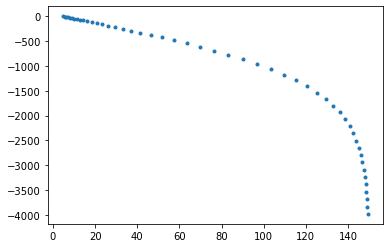

In [60]:
plt.plot(dz, -z, '.')

In [61]:
len(z)

50

## Horizontal grid

In [4]:
x = np.linspace(0, Lx, nx, endpoint=False) + dx/2
y = np.linspace(0, Ly, ny, endpoint=False) + dy/2
X,Y = np.meshgrid(x, y)

xSPC = np.linspace(x0SP, x0SP + LxSP, nx, endpoint=False) + dxSP/2
ySPC = np.linspace(y0SP, y0SP + LySP, ny, endpoint=False) + dySP/2
XSPC,YSPC = np.meshgrid(xSPC, ySPC)

xSPF = np.linspace(x0SP, x0SP + LxSP, nx+1, endpoint=True)
ySPF = np.linspace(y0SP, y0SP + LySP, ny+1, endpoint=True)
# XSPF,YSPF = np.meshgrid(xSPF, ySPF)




## Define the shelf geometry

shelf geometry from Stewart and Thompson (2013) - https://doi.org/10.1175/JPO-D-12-0205.1
Plus a 1 km high meridional ridge.

Add an Antarctic Peninsula and a Wedell Sea


In [5]:
# Gaussian ridge
ridge = Hridge*np.exp(-((X-Xridge)/Wridge)**2)
ridge = Habyss - ridge

In [6]:
# define the embayment using an F distribution
embayment = scipy.stats.f.pdf(6*(x-Xp)/Lx, 3,100)
# normalise the embayment function
embayment = embayment/embayment.max()
# define peninsula using a "Witch of Agnesi" function following Munday & Marshall (2005)
peninsula = (Hp*Wp*Wp / (Wp*Wp + (x - Xp)**2))
# Combine them all to make the coastline
coastline = Wc + peninsula - Wc*embayment


In [7]:
# plt.plot(x, embayment)
# plt.plot(x, coastline)


In [8]:
# create bathymetry with ridge and shelf
# shelf is a tanh, and knows about the ridge so the slope changes very slightly near the ridge
bathy = Hshelf + 0.5*(ridge - Hshelf)*(1 + np.tanh((Y - Yshelf)/Wshelf) )

bathy = xr.DataArray(-bathy, coords={ 'y':y, 'x':x}, dims=['y', 'x'])

# set area south of coastline to be land
bathy = bathy.where(Y>coastline, 0)

bathySP = xr.DataArray(bathy, coords={'ySPC':ySPC, 'xSPC':xSPC}, dims=['ySPC', 'xSPC'])


In [9]:
bathy.data.astype('>f4').tofile('{0}bathy.bin'.format(input_dir))

NameError: name 'input_dir' is not defined

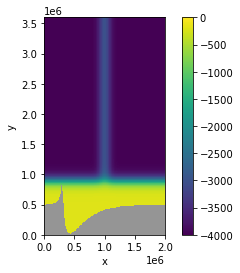

In [15]:
bathy.plot()
ax = plt.gca()
ax.set_aspect('equal')

ax.pcolormesh(bathy.x, bathy.y, bathy.where(bathy==0), cmap='Greys', vmin=-1, vmax=1)

plt.savefig('MITgcm_bathy.png', dpi=200, bbox_inches='tight')

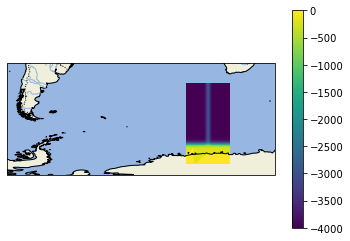

In [69]:



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-80, 40, -80, -30], crs=ccrs.PlateCarree())

bathySP.plot(ax=ax, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)



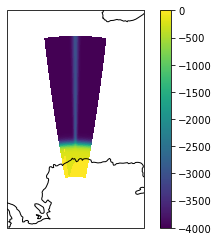

In [73]:
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=10, central_latitude=-50), )

# ax.set_global()
bathySP.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-10, 30, -90, -30])


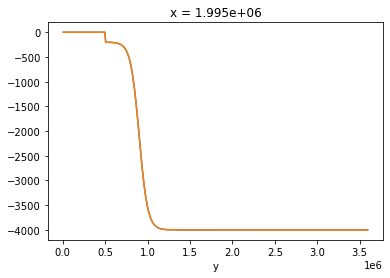

In [74]:
# Is is periodic? Plot the profiles at the two ends to check
bathy.isel(x=1).plot()
bathy.isel(x=-1).plot()



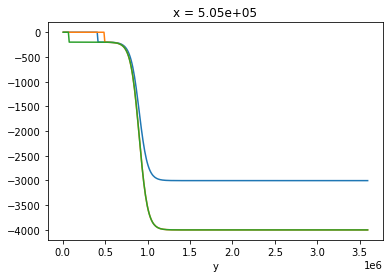

In [75]:
# How different is the slope near the ridge?
# Not too different, but, it definitely deviates
bathy.sel(x=1e6, method='nearest').plot()
bathy.sel(x=1.5e6, method='nearest').plot()
bathy.sel(x=0.5e6, method='nearest').plot()

(-4100.0, 0.0)

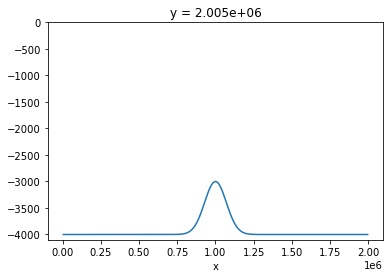

In [76]:
# what's the cross-section of the ridge?
bathy.sel(y=2e6, method='nearest').plot()

plt.ylim(-4100, 0)

# Surface forcings

Use JRA-55 do neutral year, 1 May 1990 to 30 April 1991, as recommended by Stewart et al. (2020) - https://www.sciencedirect.com/science/article/abs/pii/S1463500319302768

Zonal mean, monthly mean. Removes synoptic variability, but is probably simpler given the channel geometry, and cartesian grid. Otherwise, I'd need to use a spherical grid (not impossible) or scale the atmospheric forcing (very weird). Zonal mean allows me to choose between spherical and Cartesian without any issues.

In [77]:
atemp = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/tas/gr/v20200916/*')
atemp = atemp.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
atemp_forcing = atemp.groupby('time.month').mean(dim='time').mean(dim='lon')

atemp_JRA55do_EXF = atemp_forcing.interp(lat=ySPC)
atemp_JRA55do_EXF = atemp_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
atemp_JRA55do_EXF['tas'].load().data.astype('>f4').tofile('{0}atemp_JRA55do_EXF.bin'.format(input_dir))



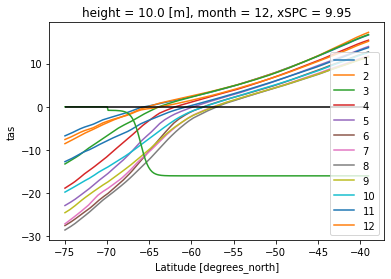

In [106]:
for month in range(1,13):
    (atemp_JRA55do_EXF['tas'].sel(month=month).sel(xSPC=10., method='nearest')-273.15).plot(label=month)
plt.plot(ySPC, bathySP.sel(xSPC=1, method='nearest')/250)
plt.legend()
plt.hlines(0, y0SP, yNSP, colors='k')

In [79]:
uwind = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/uas/gr/v20200916/*')
uwind = uwind.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
uwind_forcing = uwind.groupby('time.month').mean(dim='time').mean(dim='lon')

uwind_JRA55do_EXF = uwind_forcing.interp(lat=ySPC)
uwind_JRA55do_EXF = uwind_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPF':xSPF[:-1]}, dims=['xSPF'])
uwind_JRA55do_EXF['uas'].load().data.astype('>f4').tofile('{0}uwind_JRA55do_EXF.bin'.format(input_dir))




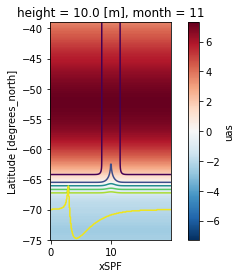

In [80]:
uwind_JRA55do_EXF['uas'].sel(month=11).plot()
plt.contour(xSPC, ySPC, bathySP, levels=[-3900, -3000, -2000, -1000, -500, -100, 0])
ax = plt.gca()
ax.set_aspect('equal')

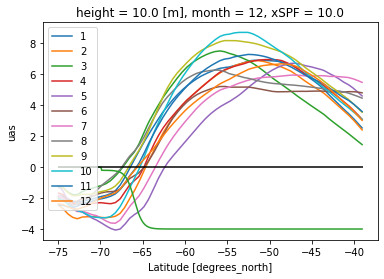

In [107]:
for month in range(1,13):
    uwind_JRA55do_EXF['uas'].sel(month=month).sel(xSPF=10.).plot(label=month)
plt.plot(ySPC, bathySP.sel(xSPC=1, method='nearest')/1000)
plt.legend()
plt.hlines(0, y0SP, yNSP, colors='k')

In [82]:
vwind = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/vas/gr/v20200916/*')
vwind = vwind.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
vwind_forcing = vwind.groupby('time.month').mean(dim='time').mean(dim='lon')


vwind_JRA55do_EXF = vwind_forcing.interp(lat=ySPF[:-1])
vwind_JRA55do_EXF = vwind_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
vwind_JRA55do_EXF['vas'].load().data.astype('>f4').tofile('{0}vwind_JRA55do_EXF.bin'.format(input_dir))




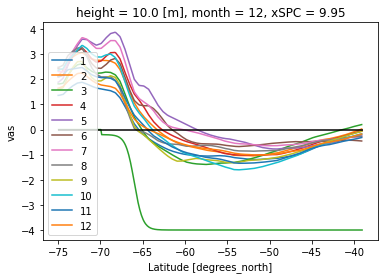

In [108]:
for month in range(1,13):
    vwind_JRA55do_EXF['vas'].sel(month=month).sel(xSPC=10., method='nearest').plot(label=month)
plt.plot(ySPC, bathySP.sel(xSPC=1, method='nearest')/1000)
plt.legend()
plt.hlines(0, y0SP, yNSP, colors='k')

In [84]:
# Let's not use runoff in the control simulation. The geomtery is too idealised for this to make sense anyway.
# Better to use it as a potential perturbation later on.

# runoff = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/land/day/friver/gr/v20200916/*')
# runoff = runoff.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-70,-40))
# need to adjust units from kg/m**2/s to m/s by dividing by 1e3
# runoff_forcing = runoff.groupby('time.month').mean(dim='time').mean(dim='lon')



In [85]:
aqh = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/huss/gr/v20200916/*')
aqh = aqh.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
aqh_forcing = aqh.groupby('time.month').mean(dim='time').mean(dim='lon')

aqh_JRA55do_EXF = aqh_forcing.interp(lat=ySPC)
aqh_JRA55do_EXF = aqh_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
aqh_JRA55do_EXF['huss'].load().data.astype('>f4').tofile('{0}aqh_JRA55do_EXF.bin'.format(input_dir))




In [86]:
precip_rain = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr/prra/gr/v20200916/*')
precip_rain = precip_rain.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
precip_rain_forcing = precip_rain.groupby('time.month').mean(dim='time').mean(dim='lon')
#convert from kg/m**2/s to m/s by dividing by 1e3 kg/m**3
precip_rain_forcing = precip_rain_forcing/1e3

precip_rain_JRA55do_EXF = precip_rain_forcing.interp(lat=ySPC)
precip_rain_JRA55do_EXF = precip_rain_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
precip_rain_JRA55do_EXF['prra'].load().data.astype('>f4').tofile('{0}precip_rain_JRA55do_EXF.bin'.format(input_dir))


In [ ]:
for month in range(1,13):
    precip_rain_JRA55do_EXF['prra'].sel(month=month).sel(xSPC=10., method='nearest').plot(label=month)
plt.plot(ySPC, bathySP.sel(xSPC=1, method='nearest')/1000)
plt.legend()
plt.hlines(0, y0SP, yNSP, colors='k')

In [87]:
precip_snow = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr/prsn/gr/v20200916/*')
precip_snow = precip_snow.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
#convert from kg/m**2/s to m/s by dividing by 1e3
precip_snow_forcing = precip_snow.groupby('time.month').mean(dim='time').mean(dim='lon')/1e3

precip_snow_JRA55do_EXF = precip_snow_forcing.interp(lat=ySPC)
precip_snow_JRA55do_EXF = precip_snow_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
precip_snow_JRA55do_EXF['prsn'].load().data.astype('>f4').tofile('{0}precip_snow_JRA55do_EXF.bin'.format(input_dir))




In [88]:
swdown = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr/rsds/gr/v20200916/*')
swdown = swdown.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
swdown_forcing = swdown.groupby('time.month').mean(dim='time').mean(dim='lon')

swdown_JRA55do_EXF = swdown_forcing.interp(lat=ySPC)
swdown_JRA55do_EXF = swdown_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
swdown_JRA55do_EXF['rsds'].load().data.astype('>f4').tofile('{0}swdown_JRA55do_EXF.bin'.format(input_dir))




In [89]:
lwdown = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr/rlds/gr/v20200916/*')
lwdown = lwdown.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
lwdown_forcing = lwdown.groupby('time.month').mean(dim='time').mean(dim='lon')

lwdown_JRA55do_EXF = lwdown_forcing.interp(lat=ySPC)
lwdown_JRA55do_EXF = lwdown_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
lwdown_JRA55do_EXF['rlds'].load().data.astype('>f4').tofile('{0}lwdown_JRA55do_EXF.bin'.format(input_dir))



In [90]:
apressure = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/psl/gr/v20200916/*')
apressure = apressure.sel(time=slice('1990-05-01', '1991-4-30')).sel(lat=slice(-80,-35))
apressure_forcing = apressure.groupby('time.month').mean(dim='time').mean(dim='lon')

apressure_JRA55do_EXF = apressure_forcing.interp(lat=ySPC)
apressure_JRA55do_EXF = apressure_JRA55do_EXF*xr.DataArray(np.ones([nx]), coords={'xSPC':xSPC}, dims=['xSPC'])
apressure_JRA55do_EXF['psl'].load().data.astype('>f4').tofile('{0}apressure_JRA55do_EXF.bin'.format(input_dir))



# Initial hydrography and sponge
Take a zonal mean of World Ocean Atlas 2018 for initial conditions and use northern most 100 km of it for the sponge.

In [91]:
ds_temperature = xr.open_dataset('/g/data/jk72/ed7737/world-ocean-atlas/woa18_decav_t00_04.nc', decode_times=False)
ds_salt = xr.open_dataset('/g/data/jk72/ed7737/world-ocean-atlas/woa18_decav_s00_04.nc', decode_times=False)

In [92]:
z.max()

3982.2608621419267

In [93]:
temperature_profile = ds_temperature['t_an'].sel(lat=yNSP, method='nearest').mean(dim='lon').squeeze()
temperature_profile = temperature_profile.interp(depth = z*ds_temperature['depth'].max().values/z.max())

salt_profile = ds_salt['s_an'].sel(lat=yNSP, method='nearest').mean(dim='lon').squeeze()
salt_profile = salt_profile.interp(depth = z*ds_temperature['depth'].max().values/z.max())


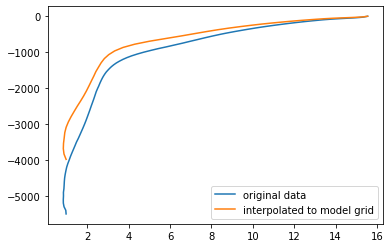

In [94]:
plt.plot(ds_temperature['t_an'].sel(lat=yNSP, method='nearest').mean(dim='lon').squeeze(), -ds_temperature['depth'], label='original data')
plt.plot(temperature_profile, -z, label='interpolated to model grid')
plt.legend()

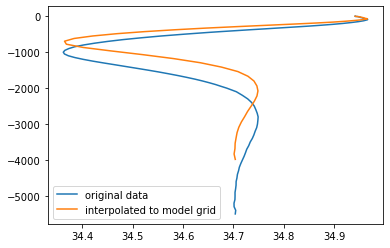

In [95]:
plt.plot(ds_salt['s_an'].sel(lat=yNSP, method='nearest').mean(dim='lon').squeeze(), -ds_salt['depth'], label='original data')
plt.plot(salt_profile, -z, label = 'interpolated to model grid')
plt.legend()

In [109]:
WOA_salt, foo = xr.broadcast(salt_profile, bathy)



In [111]:
temperature_scale = xr.ones_like(foo)*foo.y/foo.y.max()
del foo

In [113]:

WOA_temperature = temperature_profile*temperature_scale


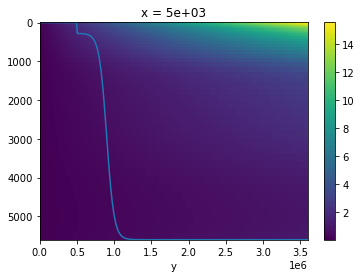

In [131]:
WOA_temperature.sel(x=1e6, method='nearest').plot(yincrease=False)
(-bathy*1.4).sel(x=0, method='nearest').plot(yincrease=False)

In [124]:
WOA_temperature.data.astype('>f4').tofile('{0}WOA_temperature_IC.bin'.format(input_dir))
WOA_salt.data.astype('>f4').tofile('{0}WOA_salt_IC.bin'.format(input_dir))

## RBCS mask

In [102]:
Wmask = 20e3
Ymask = Ly - 2.5*Wmask

# define using a tanh to ramp from zero to one
mask_RBCS = 0.5*(1 + np.tanh((Y - Ymask)/Wmask))

mask_RBCS = xr.DataArray(mask_RBCS, coords={ 'y':y, 'x':x}, dims=['y', 'x'])
# broadcast to the three spatial dimensions
mask_RBCS = xr.DataArray(np.ones([len(z)]), coords={'z':z}, dims=['z'])*mask_RBCS


(0.0, 1.0)

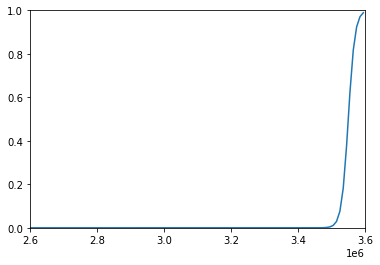

In [104]:
plt.plot(y, mask_RBCS.sel(z=0, method='nearest').sel(x=0, method='nearest'))
plt.xlim(2.6e6,Ly)
plt.ylim(0,1)

In [105]:
mask_RBCS.data.astype('>f4').tofile('{0}mask_RBCS.bin'.format(input_dir))